<a href="https://colab.research.google.com/github/dsanroman96/Machine-Learning-Projects/blob/main/Multi_Digit_Recoginizer_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Digit Recognizer**

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
 
import pandas as pd
 
import numpy as np
 
import random

import matplotlib.pyplot as plt
import matplotlib as mpl

## Preprocessing Data

In [ ]:
train_df = pd.read_csv("archive/train.csv")
test_df = pd.read_csv("archive/test.csv")
 
train_images = "archive/train_images/" + train_df.iloc[:, 0].values
test_images = "archive/test_images/" + test_df.iloc[:, 0].values
 
train_labels = train_df.iloc[:, 1:].values
test_labels = test_df.iloc[:, 1:].values

In [ ]:
def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
 
    image.set_shape((64, 64, 1))
    label[0].set_shape([])
    label[1].set_shape([])
 
    labels = {"output_1": label[0], "output_2": label[1]}
    return image, labels

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset.shuffle(buffer_size=len(train_labels))
    .map(read_image)
    .batch(batch_size=64)
    .prefetch(buffer_size=AUTOTUNE)
)
 
test_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = (
    test_dataset.map(read_image)
    .batch(batch_size=64)
    .prefetch(buffer_size=AUTOTUNE)
)

## Data Display

In [ ]:
def print_gallery(images, labels=None):
  num_images = images.shape[0]
  
  for i in range(num_images):
    plt.subplot(1, num_images+1, i+1)
    image = images[i]
    image = tf.squeeze(image, axis=2)
    plt.imshow(image, cmap="gray")

    if labels is not None:
      plt.title("Prediction:" + str(labels[i][0]) + "/" + str(labels[i][1]))

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [ ]:
def random_images(num_images, ds_images, ds_labels=None):
  labels = []
  images = []
  print_labels = False
  if ds_labels is not None: print_labels = True
 
  for i in range(num_images):
    num = random.randint(0, ds_images.shape[0])
    image = tf.io.read_file(ds_images[num])
    image = tf.image.decode_image(image, channels=1, dtype=tf.float32)
    images.append(image)

    if print_labels: labels.append(ds_labels[num])

  images = np.asarray(images)

  if print_labels:
    return images, labels
  return images

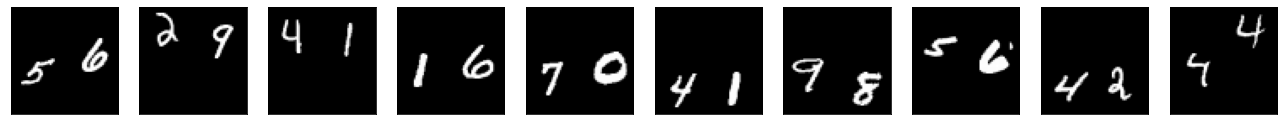

In [ ]:
mpl.rcParams['figure.figsize'] = (25,25)
mpl.rcParams['axes.grid'] = False

example_imgs = random_images(10, train_images)
print_gallery(example_imgs)

## **Model**

In [ ]:
class CNNBlock(layers.Layer):
  def __init__(self, channels, kernel_size=3, padding="same"):
    super(CNNBlock, self).__init__()
    self.conv = layers.Conv2D(channels, kernel_size, padding = padding)
    self.bn = layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv(input_tensor)
    x = self.bn(x, training = training)
    x = tf.nn.relu(x)
    return x


class ResBlock(layers.Layer):
  def __init__(self, channels):
    super(ResBlock, self).__init__()
    self.cnn1 = CNNBlock(channels[0])
    self.cnn2 = CNNBlock(channels[1])
    self.cnn3 = CNNBlock(channels[2], padding="valid")
    self.max_pooling = layers.MaxPooling2D()

  def call(self, input_tensor, training=False):
    x = self.cnn1(input_tensor, training=training)
    x = self.cnn2(x, training=training)
    x = self.cnn3(x, training=training)
    x = self.max_pooling(x)
    return x


class MyModel(keras.Model):
  def __init__(self, num_classes=10):
    super(MyModel, self).__init__(name="Custom_Model")
    self.block1 = ResBlock([16,16,32])
    self.block2 = ResBlock([32,32,64])
    self.block3 = ResBlock([64,64,128])
    self.global_pooling = layers.GlobalAveragePooling2D()
    self.output1 = layers.Dense(num_classes, activation="softmax")
    self.output2 = layers.Dense(num_classes, activation="softmax")


  def call(self, input_tensor, training=False):
    x = self.block1(input_tensor, training=training)
    x = self.block2(x, training=training)
    x = self.block3(x, training=training)
    x = self.global_pooling(x, training=training)
    x1 = self.output1(x)
    x2 = self.output2(x)
    return x1, x2

In [ ]:
def run_model(model, train, test, learning_rate, batch_size, epochs, summary=True):
  model.compile(
      loss = [
              tf.keras.losses.SparseCategoricalCrossentropy(),
              tf.keras.losses.SparseCategoricalCrossentropy()
              ],
      optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
      metrics = ["accuracy"]
  )
 
  if summary:
      model.summary()
 
  print("Training:")
  model.fit(train, batch_size=64, epochs=epochs, verbose=2)
  print()
  print("Evaluate:")
  model.evaluate(test, batch_size=64, verbose=2)
 
  return model

In [ ]:
def predict_numers(num_images, test_images):
  images = random_images(num_images, test_images)
  
  results = model(images)

  result_labels = []
  for i in range(num_images):
    result_labels.append([tf.math.argmax(results[0][i]).numpy(), tf.math.argmax(results[1][i]).numpy()])

  print_gallery(images, result_labels)

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.002

model = MyModel(10)

model = run_model(model, train_dataset, test_dataset, LEARNING_RATE, BATCH_SIZE, 3, False)

Training:
Epoch 1/3
1000/1000 - 29s - loss: 0.3869 - output_1_loss: 0.1959 - output_2_loss: 0.1910 - output_1_accuracy: 0.9482 - output_2_accuracy: 0.9502
Epoch 2/3
1000/1000 - 24s - loss: 0.0626 - output_1_loss: 0.0317 - output_2_loss: 0.0309 - output_1_accuracy: 0.9912 - output_2_accuracy: 0.9912
Epoch 3/3
1000/1000 - 24s - loss: 0.0454 - output_1_loss: 0.0232 - output_2_loss: 0.0222 - output_1_accuracy: 0.9932 - output_2_accuracy: 0.9933

Evaluate:
1000/1000 - 22s - loss: 0.0935 - output_1_loss: 0.0470 - output_2_loss: 0.0465 - output_1_accuracy: 0.9868 - output_2_accuracy: 0.9858


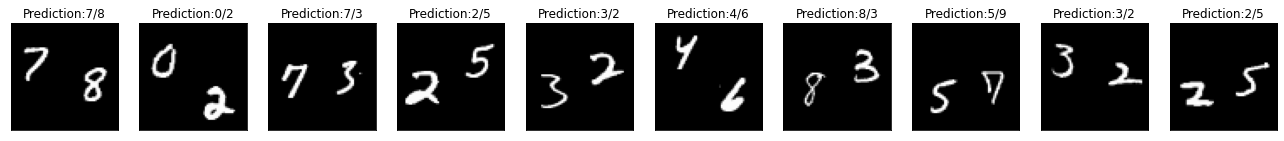

In [ ]:
predict_numers(10, test_images)